In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

In [7]:
# We cBase.classes.keys()an view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

In [10]:
#Importing inspect to see the column names
from sqlalchemy import  inspect
inspector = inspect(engine)

In [11]:
#Inspecting table measurement
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
#Inspecting table station
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [14]:
# Calculate the date 1 year ago from the last data point in the database

# Querying the DB for the latest date we have data for
lastDate=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
for date in lastDate:
    dataArray = date.split("-")
    (year,month,day) = dataArray

# Calculating one year before that
year_ago = dt.date(int(year),int(month),int(day)) - dt.timedelta(days=365)
year_ago=year_ago.isoformat()
print(f'1 year ago from the last data point in the database is {year_ago}')

1 year ago from the last data point in the database is 2016-08-23


In [15]:
# Perform a query to retrieve the data and precipitation scores

# QUerying the last 12 months of data
results=session.query(Measurement).filter(Measurement.date >= year_ago).all()

# Creating empty arrays to append data to later
dates=[]
prcp=[]

# Going through the values and appending data to the srrays created before
for row in results:
    dates.append(row.date)
    prcp.append(row.prcp)

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column

# Creating a DF to present the data
last12Months_df=pd.DataFrame({
    'Date':dates,
    'Precipitation':prcp
})

# Setting the Date as the index of teh DF
last12Months_df=last12Months_df.set_index('Date')

In [17]:
# Sort the dataframe by date
last12Months_df=last12Months_df.sort_values(by='Date')
last12Months_df

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


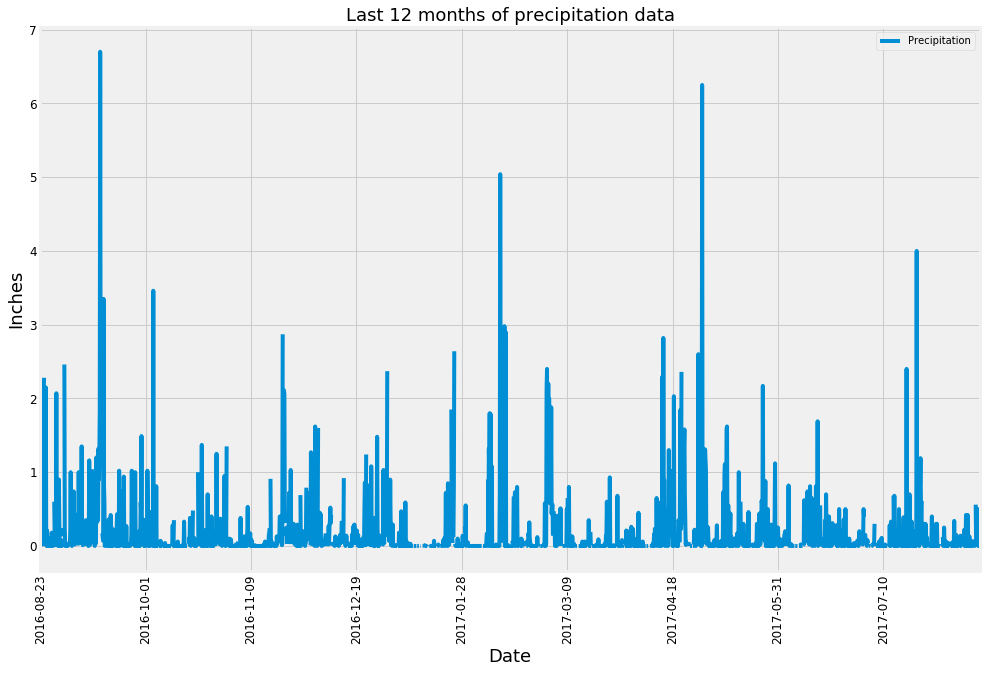

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data

# Ploting and saving the Last 12 months of precipitation Data
ax=last12Months_df.plot(figsize=(15,10),rot=90,fontsize=12)
plt.xlabel("Date",fontsize=18)
plt.ylabel("Inches",fontsize=18)
plt.title('Last 12 months of precipitation data',fontsize=18)
plt.savefig('images/precipitation data.png')
plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last12Months_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# Design a query to show how many stations are available in this dataset?

# Query the stations table in the DB and do a count
stationsCount=session.query(Station.station).count()
print(f'There are {stationsCount} stations available in this dataset')

There are 9 stations available in this dataset


In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

# Querying DB for the most active station. Had to join the 2 tables to get the name of the station.
results=session.query(Station.station,Station.name,func.count(Measurement.id)).\
    filter(Station.station == Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()

# Created the empty arrays to append values to later
stationId=[]
stationName=[]
stationCount=[]

# Appending the values from the query to the arrays created above
for id,name,count in results:
    stationId.append(id)
    stationName.append(name)
    stationCount.append(count)

# Creating a DataFrame just for the values to be presented in a better form
stationCount_df=pd.DataFrame({
    'Station ID':stationId,
    'Station Name':stationName,
    'Count':stationCount
})

#Setting the ID as the index
stationCount_df=stationCount_df.set_index('Station ID')
#Id of the most active station
maxCountStation=stationCount_df['Count'].idxmax()

print(f"The most active station is {maxCountStation} - {stationCount_df.loc[maxCountStation,'Station Name']}")

stationCount_df
      

The most active station is USC00519281 - WAIHEE 837.5, HI US


,Station Name,Count
Station ID,,
USC00519281,"WAIHEE 837.5, HI US",2772
USC00519397,"WAIKIKI 717.2, HI US",2724
USC00513117,"KANEOHE 838.1, HI US",2709
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
USC00517948,"PEARL CITY, HI US",1372
USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# Querying the DB for the max, min and avg temp of the most active station
results=session.query(Measurement.station,func.max(Measurement.tobs),func.min(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station==maxCountStation).\
    group_by(Measurement.station).all()

# Unpacking the values
for value in results:
    (id,max,min,avg)=value

# Creating a Data Frame just to better present the results
stationStats_df=pd.DataFrame({
    'Station ID':[id],
    'Max Temperature':max,
    'Min Temperature':min,
    'Avg Temperature':round(avg,2)
})

# Setting the ID as the index 
stationStats_df=stationStats_df.set_index('Station ID')
stationStats_df

,Max Temperature,Min Temperature,Avg Temperature
Station ID,,,
USC00519281,85.0,54.0,71.66


In [23]:
# Choose the station with the highest number of temperature observations.

# Querying for the station with the highest number of temp observations. 
# The difference from the query below is that the previous one I counte on Measurement.id and this one on Measurement.tobs
data=session.query(Measurement.station,Station.name,func.count(Measurement.tobs)).\
    filter(Measurement.station==Station.station).\
    group_by(Measurement.station,Station.station).\
    order_by(func.count(Measurement.tobs).desc()).\
    first()

# Unpacking the results
(maxStationID,maxStationName,temp) = data
print(f'The Station with the highest number of temperature observations is {maxStationID} - {maxStationName}')

The Station with the highest number of temperature observations is USC00519281 - WAIHEE 837.5, HI US


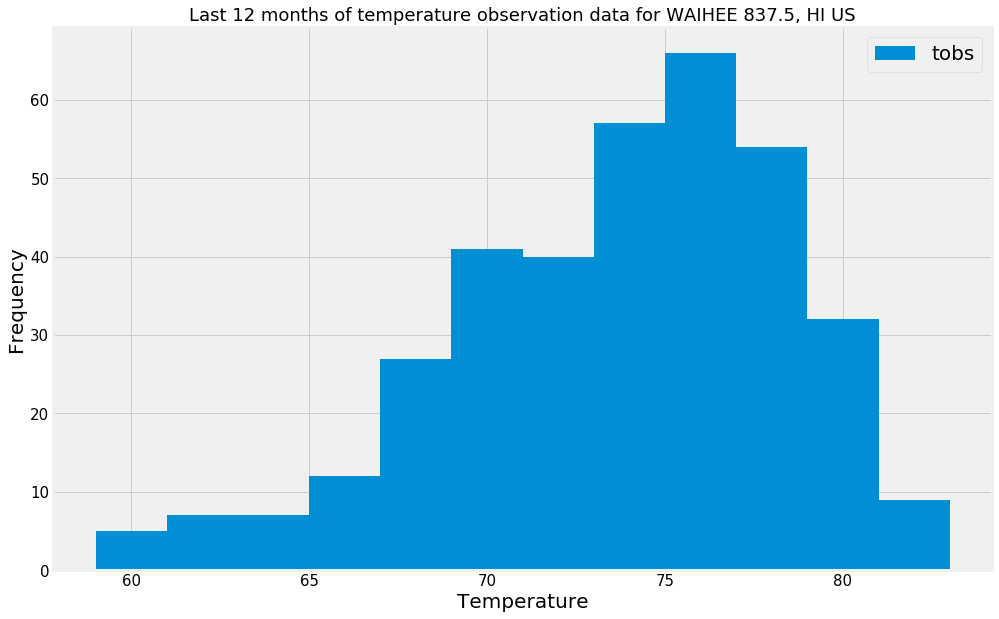

In [24]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Querying the DB for the latest date we have a temp observation for station USC00519281
lastDate=session.query(Measurement.date).filter(Measurement.station == maxStationID).order_by(Measurement.date.desc()).first()
for date in lastDate:
    dataArray = date.split("-")
    (year,month,day) = dataArray

# Calculating one year before that to have the start and end date for the query
year_agoStation = dt.date(int(year),int(month),int(day)) - dt.timedelta(days=365)

# Querying the DB for the last 12 months of data for station USC00519281.
results=session.query(Measurement).filter(Measurement.date >= year_agoStation).\
    filter(Measurement.station == maxStationID).all()

# Creating empty arrays to add data to later
USC00519281date=[]
USC00519281temp=[]

# Appending data to the arrays created before
for row in results:
    USC00519281date.append(row.date)
    USC00519281temp.append(row.tobs)

# Creating a DF to present the data
USC00519281_df=pd.DataFrame({
    'Date':USC00519281date,
    'Temperature':USC00519281temp
})

#Creating a saving a histogram plot to display the Frequency of temperature values in F.
ax=USC00519281_df.plot.hist('Temperature',figsize=(15,10),bins=12,fontsize=15)
ax.legend(['tobs'],loc='upper right',fontsize=20)
ax.set_xlabel("Temperature",fontsize=20)
ax.set_ylabel("Frequency",fontsize=20)
plt.title(f'Last 12 months of temperature observation data for {maxStationName}',fontsize=18)
plt.savefig('images/histogram_tobs.png')

## Bonus Challenge Assignment

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
########## Temperature Analysis I ###############

# Started by creating a function that will return the average temperature 
# for a given month at all stations accross all years available

def month_temp_values(month):
    """Daily Normals.
    Args:
        month (str): A date string in the format '%m'
    Returns:
        The average temperature for the given month
    """
    return session.query(Measurement.tobs).\
        filter(func.strftime("%m", Measurement.date) == month).all()

In [27]:
junTobs=[]
decTobs=[]

for value in month_temp_values('06'):
        junTobs.append(*value)
for value in month_temp_values('12'):
        decTobs.append(*value)

In [28]:
from scipy import stats
from scipy import mean

avgJuneTobs=mean(junTobs)
avgDecTobs=mean(decTobs)

avgTobs=[round(avgJuneTobs,2),round(avgDecTobs,2)]

(stats,pvalue)=stats.ttest_ind(junTobs, decTobs)

print(f'''I used an unpaired/independent T-test because I am comparing 2 different samples. They are not related.

Here are the values I got:
 - t value: {round(stats,2)}
 - p value: {pvalue}

''')

I used an unpaired/independent T-test because I am comparing 2 different samples. They are not related.

Here are the values I got:
 - t value: 31.6
 - p value: 3.9025129038616655e-191




In [29]:
# Created an array with the months we want to look at

monthsName=['June','December']

jun_dec_df=pd.DataFrame({
    'Month':monthsName,
    'Avg Temperature (F)':avgTobs,
})

jun_dec_df.set_index('Month')

,Avg Temperature (F)
Month,
June,74.94
December,71.04


In [31]:
########## Temperature Analysis II ###############

# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those samedef calc_temps(start_date, end_date): dates.

# Printing what are the times for my trip
print('My Trip will be the from March 1st to March 7th in 2018')

# Saving the start and end dates of my trip
tripStartDate='2018-03-01'
tripEndDate='2018-03-07'

# Calculate the dates for 1 year before 
from datetime import date
priorYearStart=f"{(date.fromisoformat(tripStartDate).year)-1}-{(date.fromisoformat(tripStartDate)).strftime('%m-%d')}"
priorYearEnd=f"{(date.fromisoformat(tripEndDate).year)-1}-{(date.fromisoformat(tripEndDate)).strftime('%m-%d')}"

# Call the function created before for the dates intervals calculated
results=calc_temps(priorYearStart, priorYearEnd)

# Unpacked the results
for value in results:
    (tempMin,tempAvg,tempMax)=value
    
# Printing the findings
print(f'''
At the same time the year before we had:
Minimum Temperature = {round(tempMin,2)}F
Average Temperature = {round(tempAvg,2)}F
Maximum Temperature = {round(tempMax,2)}F
''')

My Trip will be the from March 1st to March 7th in 2018

At the same time the year before we had:
Minimum Temperature = 62.0F
Average Temperature = 71.02F
Maximum Temperature = 78.0F



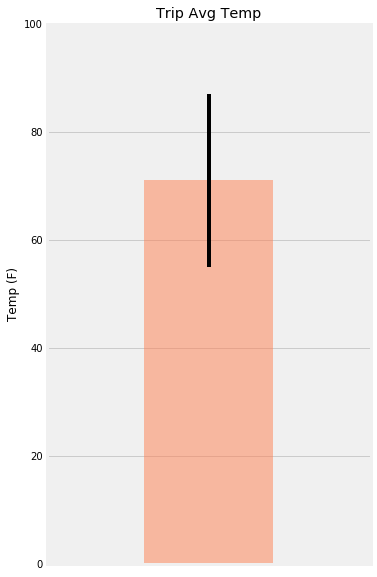

In [32]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Calculating the values for the y error bar
error=tempMax-tempMin

# Creating and saving a single bar plot for the average 
# temperature the same time as my trip but the previous year

fig = plt.figure(figsize=(6,10))
ax = fig.add_axes([0.1,0.1,0.75,0.75])
plt.bar(1,tempAvg,width=0.8,yerr=error,color='coral',alpha=0.5)
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Temp (F)')
ax.set_ylim(0,100)
ax.set_xlim(0,2)
ax.set_xticks([])
plt.savefig('images/bonus_TempAnalysis2_AvgTemp.png')
plt.show()

In [33]:
########## Daily Rainfall Average ##########

# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Querying the DB for total precipitation for each station for the previous' year matching date
results=session.query(Station.station,Station.name,func.sum(Measurement.prcp)).\
                    filter(Station.station==Measurement.station).\
                    filter(Measurement.date >= priorYearStart).filter(Measurement.date <= priorYearEnd).\
                    group_by(Station.station).group_by(Station.name).\
                    order_by(func.sum(Measurement.prcp).desc())

# Creating empty arrays to append values to later on
id=[]
name=[]
prcp=[]

# Unpacking and appending the values to the empty arrays created
for value in results:
    (stationid,stationname,totalprcp)=value
    id.append(stationid)
    name.append(stationname)
    prcp.append(totalprcp)

# Creating DF to show the data
rainfall_df=pd.DataFrame({
    'Station ID':id,
    'Station':name,
    'Total Prcp':prcp
})
rainfall_df

,Station ID,Station,Total Prcp
0,USC00513117,"KANEOHE 838.1, HI US",4.80
1,USC00519281,"WAIHEE 837.5, HI US",4.71
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",3.49
3,USC00517948,"PEARL CITY, HI US",2.98
4,USC00519397,"WAIKIKI 717.2, HI US",2.74
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2.32
6,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",1.12


In [34]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    

In [35]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates
tripDates=pd.date_range(start=tripStartDate,end=tripEndDate)

dateStrings=[]
# Stip off the year and save a list of %m-%d strings
for value in tripDates:
    dateStrings.append(f"{value.strftime('%m')}-{value.strftime('%d')}")

normals=[]
# Loop through the list of %m-%d strings and calculate the normals for each date
for date in dateStrings:                       
    for value in daily_normals(date):
        normals.append(value)
normals

[(64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0),
 (60.0, 69.20338983050847, 76.0),
 (60.0, 69.17241379310344, 78.0)]

In [36]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df=pd.DataFrame(np.array(normals),columns=['Min Temp', 'Avg Temp', 'Max Temp'])
normals_df['Date']=tripDates.strftime("%Y-%m-%d")
normals_df.set_index('Date')


,Min Temp,Avg Temp,Max Temp
Date,,,
2018-03-01,64.0,70.032787,76.0
2018-03-02,61.0,70.366667,78.0
2018-03-03,60.0,70.068966,78.0
2018-03-04,57.0,69.272727,77.0
2018-03-05,60.0,67.890909,76.0
2018-03-06,60.0,69.203390,76.0
2018-03-07,60.0,69.172414,78.0


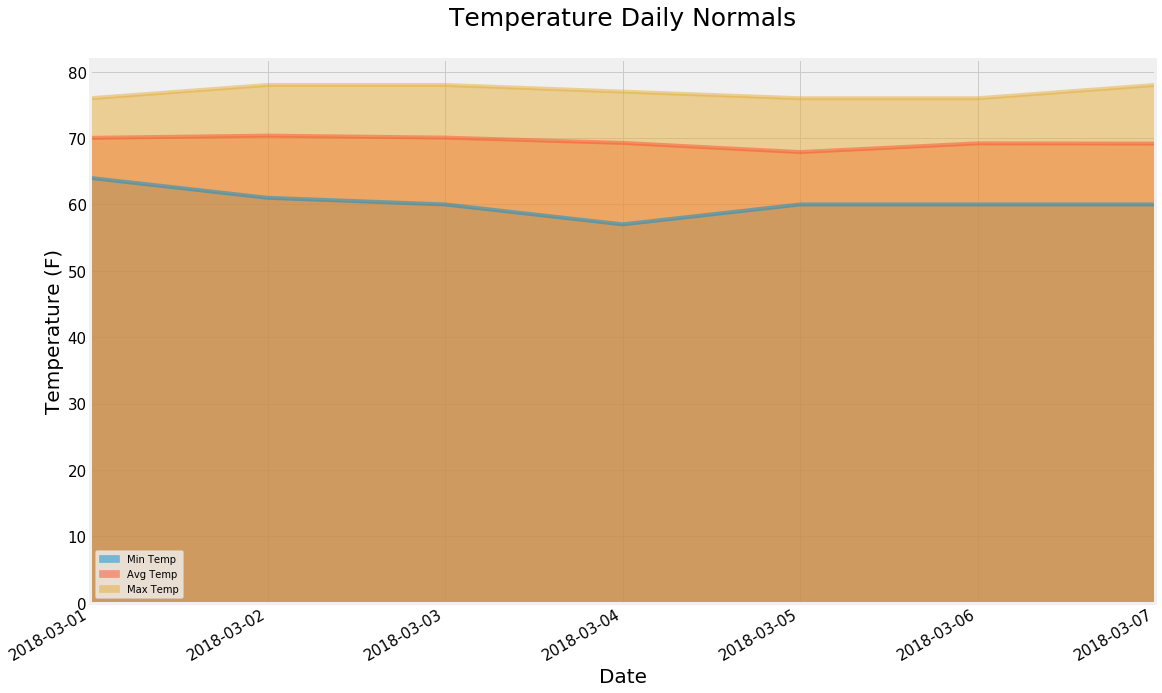

In [37]:
# Plot the daily normals as an area plot with `stacked=False`
ax=normals_df.plot.area('Date',stacked=False,figsize=(17,10),fontsize=15)
ax.set_xticklabels(normals_df['Date'], rotation=30, ha='right')
ax.set_ylabel('Temperature (F)',fontsize=20)
ax.set_xlabel('Date',fontsize=20)
ax.set_title('Temperature Daily Normals\n',fontsize=25)
plt.savefig('images/bonus_DailyRainfallAvg_TempDailyNormals')